# SAC

In [ ]:
!apt-get install -y swig

In [ ]:
!pip install gymnasium
!pip install gymnasium[box2d]

In [3]:
# Imports
from typing import Iterable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## Critic
Define Critic network which will estimate the expected cumulative reward.

In [4]:
class Critic(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int):
        """
        Initialize the Critic network.

        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()


    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, action], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out


## Actor
Definition of the Actor network. SAC uses a stochastic policy. This means that the actor outputs a probability distribution over the actions. The distribution is parameterized by a mean $\mu$ and a standard deviation $\sigma$. Typically, the stochastic policy is modeled with a squashed diagonal Gaussian distribution. The squashing function is used to ensure that the actions are within the bounds of the environment's action space.


In [5]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, action_low: np.array, action_high: np.array):
        """
        Initialize the Actor network.

        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Actor, self).__init__()
        # We are registering scale and bias as buffers so they can be saved and loaded as part of the model.
        # Buffers won't be passed to the optimizer for training!
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32)
        )

        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc_mu = nn.Linear(256, action_dim)
        self.fc_std = nn.Linear(256, action_dim)

    def forward(self, obs: torch.Tensor) -> "tuple[torch.Tensor, torch.Tensor]":
        """
        Forward pass of the actor network.

        return: mean_action, log_prob_action
        """
        x = F.relu(self.fc1(obs))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = torch.distributions.Normal(mu, std)

        action = dist.rsample()
        log_prob = dist.log_prob(action)

        # Enforcing action bounds
        adjusted_action = torch.tanh(action) * self.action_scale + self.action_bias
        adjusted_log_prob = log_prob - torch.log(self.action_scale * (1-torch.tanh(action).pow(2)) + 1e-6)
        return adjusted_action, adjusted_log_prob



## Replay Buffer

Implementation of the replay buffer

In [6]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

## Updates
Update functions for critics and actor.

 The function gets the sampled data from the replay buffer, calculates the loss of both critics, respectively, and performs an update step.

In [7]:
def update_critics(
        q1: nn.Module,
        q1_target: nn.Module,
        q1_optimizer: optim.Optimizer,
        q2: nn.Module,
        q2_target: nn.Module,
        q2_optimizer: optim.Optimizer,
        actor_target: nn.Module,
        log_ent_coef: torch.Tensor,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update both of SAC's critics for one optimizer step.

    :param q1: The first critic network.
    :param q1_target: The target first critic network.
    :param q1_optimizer: The first critic's optimizer.
    :param q2: The second critic network.
    :param q2_target: The target second critic network.
    :param q2_optimizer: The second critic's optimizer.
    :param actor: The actor network.
    :param actor_target: The target actor network.
    :param actor_optimizer: The actor's optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # Calculate the target
    with torch.no_grad():
        next_action, next_action_log_prob = actor_target(torch.as_tensor(next_obs))
        next_q1_target = q1_target(torch.as_tensor(next_obs), next_action)
        next_q2_target = q2_target(torch.as_tensor(next_obs), next_action)
        next_min_q_target = torch.min(next_q1_target, next_q2_target)

        tm = tm.view(-1, 1).float()  # Ensure tm has the right shape
        target = rew.unsqueeze(1) + gamma * (1.0 - tm) * next_min_q_target - log_ent_coef.exp() * next_action_log_prob


    for q, q_target, optimizer in [(q1, q1_target, q1_optimizer), (q2, q2_target, q2_optimizer)]:
        q_val = q(obs, act)
        loss = F.mse_loss(q_val, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def update_actor(
    q1: nn.Module,
    q2: nn.Module,
    actor: nn.Module,
    actor_optimizer: optim.Optimizer,
    obs: torch.Tensor,
    log_ent_coef: torch.Tensor,
    ):
    """
    Update the SAC's Actor network for one optimizer step.

    :param critic: The critic network.
    :param actor: The actor network.
    :param actor_optimizer: The actor's optimizer.
    :param obs: Batch of current observations.

    """
    # Actor Update
    action, action_log_prob = actor(obs)
    entropy = - log_ent_coef.exp() * action_log_prob
    q1, q2 = q1(obs, action), q2(obs, action)
    q1_q2 = torch.cat([q1, q2], dim=1)
    min_q = torch.min(q1_q2, 1, keepdim=True)[0]
    actor_loss = (- min_q - entropy).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

def update_entropy_coefficient(
        actor: nn.Module,
        log_ent_coef: torch.Tensor,
        target_entropy: float,
        ent_coef_optimizer: optim.Optimizer,
        obs: torch.Tensor,
    ):
    """
    Automatic update for entropy coefficient (alpha)

    :param actor: the actor network.
    :param log_ent_coef: tensor representing the log of entropy coefficient (log_alpha).
    :param target_entropy: tensor representing the desired target entropy.
    :param ent_coef_optimizer: torch optimizer for entropy coefficient.
    :param obs: current batch observation.
    """
    _, action_log_prob = actor(obs)
    ent_coef_loss = -(log_ent_coef.exp() * (action_log_prob + target_entropy).detach()).mean()
    ent_coef_optimizer.zero_grad()
    ent_coef_loss.backward()
    ent_coef_optimizer.step()


## Polyak Update of the target networks
The polyak update updates the target networks very slowly at every step.

In [8]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    """
    Perform a Polyak average update on ``target_params`` using ``params``:

    :param params: parameters of the original network (model.parameters())
    :param target_params: parameters of the target network (model_target.parameters())
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 1 -> Hard update, 0 -> No update
    """
    with torch.no_grad():
        for param, target_param in zip(params, target_params):
            target_param.data.mul_(1 - tau)
            torch.add(target_param.data, param.data, alpha=tau, out=target_param.data)

## SAC Agent

In [9]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class SACAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            tau=0.005,
            maxlen=100_000,
            target_entropy=-1.0,
        ):
        """
        Initialize the SAC agent.

        :param env: The environment.
        :param exploration_noise.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param tau: Polyak update coefficient.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.target_entropy=target_entropy

        # Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # Initialize two critic and one actor network
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.q1 = Critic(obs_dim, action_dim)
        self.q2 = Critic(obs_dim, action_dim)
        self.actor = Actor(obs_dim, action_dim, env.action_space.low, env.action_space.high)
        self.log_ent_coef = torch.zeros(1, requires_grad=True)

        # Initialze two target critic and one target actor networks and load the corresponding state_dicts
        self.q1_target = Critic(obs_dim, action_dim)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target = Critic(obs_dim, action_dim)
        self.q2_target.load_state_dict(self.q2.state_dict())
        self.actor_target = Actor(obs_dim, action_dim, env.action_space.low, env.action_space.high)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # Create ADAM optimizer for the Critic and Actor networks
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.ent_coef_optimizer = optim.Adam([self.log_ent_coef], lr=lr)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the SAC agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 10 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                # Choose action and execute
                with torch.no_grad():
                    action, _ = self.actor(torch.as_tensor(obs).float())
                    action = action.cpu().numpy().clip(self.env.action_space.low, self.env.action_space.high)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated),
                )

                # Sample a mini batch from the replay buffer
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                # Update the Critic network
                update_critics(self.q1, self.q1_target, self.q1_optimizer, self.q2, self.q2_target, self.q2_optimizer, self.actor_target,
                               self.log_ent_coef, self.gamma, obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch)

                # Update the Actor network
                update_actor(
                    self.q1,
                    self.q2,
                    self.actor,
                    self.actor_optimizer,
                    obs_batch.float(),
                    self.log_ent_coef,
                )

                # Update Entropy Coefficient
                update_entropy_coefficient(
                    self.actor,
                    self.log_ent_coef,
                    self.target_entropy,
                    self.ent_coef_optimizer,
                    obs_batch.float(),
                )

                # Update the target networks via Polyak Update
                polyak_update(self.q1.parameters(), self.q1_target.parameters(), self.tau)
                polyak_update(self.q2.parameters(), self.q2_target.parameters(), self.tau)
                polyak_update(self.actor.parameters(), self.actor_target.parameters(), self.tau)

                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

## 1-  Default class  

In [ ]:

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
from gym.utils.step_api_compatibility import step_api_compatibility

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError:
    raise DependencyNotInstalled("box2d is not installed, run `pip install gym[box2d]`")


if TYPE_CHECKING:
    import pygame


FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False


class CustomLunarLander(gym.Env, EzPickle):
    """
    ### Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.

    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

    To see a heuristic landing, run:
    ```
    python gym/envs/box2d/lunar_lander.py
    ```
    <!-- To play yourself, run: -->
    <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->

    ### Action Space
    There are four discrete actions available: do nothing, fire left
    orientation engine, fire main engine, fire right orientation engine.

    ### Observation Space
    The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.

    ### Rewards
    After every step a reward is granted. The total reward of an episode is the
    sum of the rewards for all the steps within that episode.

    For each step, the reward:
    - is increased/decreased the closer/further the lander is to the landing pad.
    - is increased/decreased the slower/faster the lander is moving.
    - is decreased the more the lander is tilted (angle not horizontal).
    - is increased by 10 points for each leg that is in contact with the ground.
    - is decreased by 0.03 points each frame a side engine is firing.
    - is decreased by 0.3 points each frame the main engine is firing.

    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

    An episode is considered a solution if it scores at least 200 points.

    ### Starting State
    The lander starts at the top center of the viewport with a random initial
    force applied to its center of mass.

    ### Episode Termination
    The episode finishes if:
    1) the lander crashes (the lander body gets in contact with the moon);
    2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
    3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
        a body which is not awake is a body which doesn't move and doesn't
        collide with any other body:
    > When Box2D determines that a body (or group of bodies) has come to rest,
    > the body enters a sleep state which has very little CPU overhead. If a
    > body is awake and collides with a sleeping body, then the sleeping body
    > wakes up. Bodies will also wake up if a joint or contact attached to
    > them is destroyed.

    ### Arguments
    To use to the _continuous_ environment, you need to specify the
    `continuous=True` argument like below:
    ```python
    import gym
    env = gym.make(
        "LunarLander-v2",
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    )
    ```
    If `continuous=True` is passed, continuous actions (corresponding to the throttle of the engines) will be used and the
    action space will be `Box(-1, +1, (2,), dtype=np.float32)`.
    The first coordinate of an action determines the throttle of the main engine, while the second
    coordinate specifies the throttle of the lateral boosters.
    Given an action `np.array([main, lateral])`, the main engine will be turned off completely if
    `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (in particular, the
    main engine doesn't work  with less than 50% power).
    Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left
    booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely
    from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

    `gravity` dictates the gravitational constant, this is bounded to be within 0 and -12.

    If `enable_wind=True` is passed, there will be wind effects applied to the lander.
    The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`.
    `k` is set to 0.01.
    `C` is sampled randomly between -9999 and 9999.

    `wind_power` dictates the maximum magnitude of linear wind applied to the craft. The recommended value for `wind_power` is between 0.0 and 20.0.
    `turbulence_power` dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for `turbulence_power` is between 0.0 and 2.0.

    ### Version History
    - v2: Count energy spent and in v0.24, added turbulance with wind power and turbulence_power parameters
    - v1: Legs contact with ground added in state vector; contact with ground
        give +10 reward points, and -10 if then lose contact; reward
        renormalized to 200; harder initial random push.
    - v0: Initial version

    <!-- ### References -->

    ### Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        # Compare with / without shaping, referring the state description below
        '''
        state[0]: the horizontal coordinate
        state[1]: the vertical coordinate
        state[2]: the horizontal speed
        state[3]: the vertical speed
        state[4]: the angle
        state[5]: the angular speed
        state[6]: first leg contact
        state[7]: second leg contact
        '''
        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            + 10 * state[6]
            + 10 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.03

        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if not self.lander.awake:
            terminated = True
            reward = +100

        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[box2d]`"
            )

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W, VIEWPORT_H))

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (0, 0, 0), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

                for x in [self.helipad_x1, self.helipad_x2]:
                    x = x * SCALE
                    flagy1 = self.helipad_y * SCALE
                    flagy2 = flagy1 + 50
                    pygame.draw.line(
                        self.surf,
                        color=(255, 255, 255),
                        start_pos=(x, flagy1),
                        end_pos=(x, flagy2),
                        width=1,
                    )
                    pygame.draw.polygon(
                        self.surf,
                        color=(204, 204, 0),
                        points=[
                            (x, flagy2),
                            (x, flagy2 - 10),
                            (x + 25, flagy2 - 5),
                        ],
                    )
                    gfxdraw.aapolygon(
                        self.surf,
                        [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
                        (204, 204, 0),
                    )

        self.surf = pygame.transform.flip(self.surf, False, True)

        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
            s[0] is the horizontal coordinate
            s[1] is the vertical coordinate
            s[2] is the horizontal speed
            s[3] is the vertical speed
            s[4] is the angle
            s[5] is the angular speed
            s[6] 1 if first leg has contact, else 0
            s[7] 1 if second leg has contact, else 0

    Returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):

    total_reward = 0
    steps = 0
    s, info = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, terminated, truncated, info = step_api_compatibility(env.step(a), True)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or terminated or truncated:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if terminated or truncated:
            break
    if render:
        env.close()
    return total_reward


class LunarLanderContinuous:
    def __init__(self):
        raise error.Error(
            "Error initializing LunarLanderContinuous Environment.\n"
            "Currently, we do not support initializing this mode of environment by calling the class directly.\n"
            "To use this environment, instead create it by specifying the continuous keyword in gym.make, i.e.\n"
            'gym.make("LunarLander-v2", continuous=True)'
        )


from gym.envs.registration import registry, register, make, spec

register(
    id='CustomLunarLander-v1',
    entry_point='__main__:CustomLunarLander',
    max_episode_steps=1000,
    reward_threshold=200,
)


### Training

In [ ]:
env=CustomLunarLander(continuous = True)
env_name="CustomLunarLander-v2"
env.render_mode="rgb_array"

LR = 0.001
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
NUM_EPISODES = 700
DISCOUNT_FACTOR = 0.99
TARGET_ENTROPY = -1.0

# Train SAC
agent = SACAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
    target_entropy=TARGET_ENTROPY,
)
stats = agent.train(NUM_EPISODES)

<ipython-input-7-d69ad675e933>:50: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_val, target)


Episode 10 of 700  Time Step: 786
Episode 20 of 700  Time Step: 2376
Episode 30 of 700  Time Step: 4124
Episode 40 of 700  Time Step: 7369
Episode 50 of 700  Time Step: 11691
Episode 60 of 700  Time Step: 16341
Episode 70 of 700  Time Step: 20682
Episode 80 of 700  Time Step: 25384
Episode 90 of 700  Time Step: 29647
Episode 100 of 700  Time Step: 34657
Episode 110 of 700  Time Step: 39667
Episode 120 of 700  Time Step: 44677
Episode 130 of 700  Time Step: 49687
Episode 140 of 700  Time Step: 54504
Episode 150 of 700  Time Step: 59328
Episode 160 of 700  Time Step: 63356
Episode 170 of 700  Time Step: 66873
Episode 180 of 700  Time Step: 71051
Episode 190 of 700  Time Step: 74568
Episode 200 of 700  Time Step: 78876
Episode 210 of 700  Time Step: 83318
Episode 220 of 700  Time Step: 87653
Episode 230 of 700  Time Step: 91884
Episode 240 of 700  Time Step: 94062
Episode 250 of 700  Time Step: 97186
Episode 260 of 700  Time Step: 100351
Episode 270 of 700  Time Step: 103195
Episode 280 o

In [ ]:
from google.colab import files

# # # # save the trained actor
torch.save(agent.actor, "normal.pt")
files.download('normal.pt')
# loading the trained actor
loaded_actor = torch.load("normal.pt")
loaded_actor.eval()
print(loaded_actor)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Actor(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_std): Linear(in_features=256, out_features=2, bias=True)
)


### Results

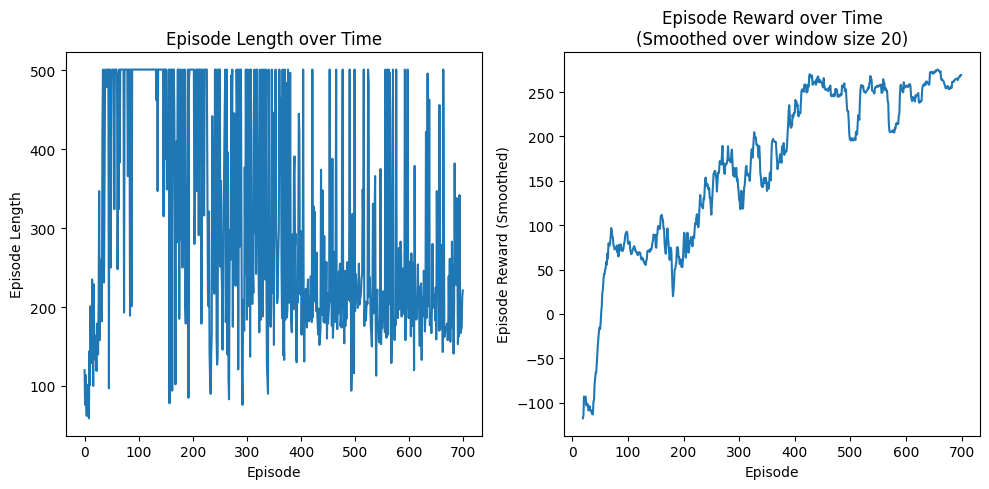

In [ ]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

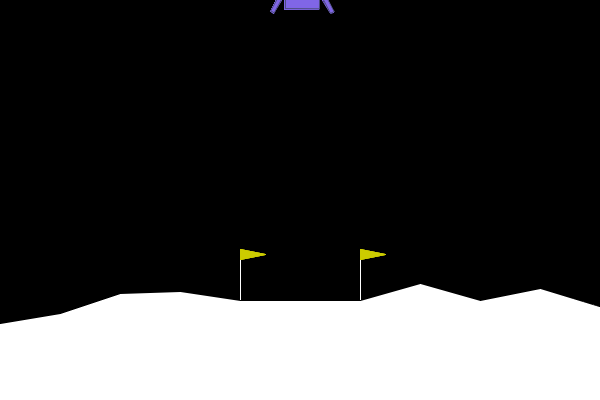

In [ ]:
from IPython.display import Image as IImage


env=CustomLunarLander(continuous = True)
env_name="CustomLunarLander-v2"
env.render_mode="rgb_array"



def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32))[0].cpu().numpy()

        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

imgs = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

## 2- Modified reward

In [10]:

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
from gym.utils.step_api_compatibility import step_api_compatibility

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError:
    raise DependencyNotInstalled("box2d is not installed, run `pip install gym[box2d]`")


if TYPE_CHECKING:
    import pygame


FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False


class CustomLunarLander(gym.Env, EzPickle):
    """
    ### Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.

    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

    To see a heuristic landing, run:
    ```
    python gym/envs/box2d/lunar_lander.py
    ```
    <!-- To play yourself, run: -->
    <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->

    ### Action Space
    There are four discrete actions available: do nothing, fire left
    orientation engine, fire main engine, fire right orientation engine.

    ### Observation Space
    The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.

    ### Rewards
    After every step a reward is granted. The total reward of an episode is the
    sum of the rewards for all the steps within that episode.

    For each step, the reward:
    - is increased/decreased the closer/further the lander is to the landing pad.
    - is increased/decreased the slower/faster the lander is moving.
    - is decreased the more the lander is tilted (angle not horizontal).
    - is increased by 10 points for each leg that is in contact with the ground.
    - is decreased by 0.03 points each frame a side engine is firing.
    - is decreased by 0.3 points each frame the main engine is firing.

    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

    An episode is considered a solution if it scores at least 200 points.

    ### Starting State
    The lander starts at the top center of the viewport with a random initial
    force applied to its center of mass.

    ### Episode Termination
    The episode finishes if:
    1) the lander crashes (the lander body gets in contact with the moon);
    2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
    3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
        a body which is not awake is a body which doesn't move and doesn't
        collide with any other body:
    > When Box2D determines that a body (or group of bodies) has come to rest,
    > the body enters a sleep state which has very little CPU overhead. If a
    > body is awake and collides with a sleeping body, then the sleeping body
    > wakes up. Bodies will also wake up if a joint or contact attached to
    > them is destroyed.

    ### Arguments
    To use to the _continuous_ environment, you need to specify the
    `continuous=True` argument like below:
    ```python
    import gym
    env = gym.make(
        "LunarLander-v2",
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    )
    ```
    If `continuous=True` is passed, continuous actions (corresponding to the throttle of the engines) will be used and the
    action space will be `Box(-1, +1, (2,), dtype=np.float32)`.
    The first coordinate of an action determines the throttle of the main engine, while the second
    coordinate specifies the throttle of the lateral boosters.
    Given an action `np.array([main, lateral])`, the main engine will be turned off completely if
    `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (in particular, the
    main engine doesn't work  with less than 50% power).
    Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left
    booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely
    from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

    `gravity` dictates the gravitational constant, this is bounded to be within 0 and -12.

    If `enable_wind=True` is passed, there will be wind effects applied to the lander.
    The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`.
    `k` is set to 0.01.
    `C` is sampled randomly between -9999 and 9999.

    `wind_power` dictates the maximum magnitude of linear wind applied to the craft. The recommended value for `wind_power` is between 0.0 and 20.0.
    `turbulence_power` dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for `turbulence_power` is between 0.0 and 2.0.

    ### Version History
    - v2: Count energy spent and in v0.24, added turbulance with wind power and turbulence_power parameters
    - v1: Legs contact with ground added in state vector; contact with ground
        give +10 reward points, and -10 if then lose contact; reward
        renormalized to 200; harder initial random push.
    - v0: Initial version

    <!-- ### References -->

    ### Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        # Compare with / without shaping, referring the state description below
        '''
        state[0]: the horizontal coordinate
        state[1]: the vertical coordinate
        state[2]: the horizontal speed
        state[3]: the vertical speed
        state[4]: the angle
        state[5]: the angular speed
        state[6]: first leg contact
        state[7]: second leg contact
        '''
        reward = 0
        shaping = (
            -150 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 50 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            + 20 * state[6]
            + 20 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.03

        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if not self.lander.awake:
            terminated = True
            reward = +200


        if reward <-400:
          self.game_over

        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[box2d]`"
            )

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W, VIEWPORT_H))

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (0, 0, 0), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

                for x in [self.helipad_x1, self.helipad_x2]:
                    x = x * SCALE
                    flagy1 = self.helipad_y * SCALE
                    flagy2 = flagy1 + 50
                    pygame.draw.line(
                        self.surf,
                        color=(255, 255, 255),
                        start_pos=(x, flagy1),
                        end_pos=(x, flagy2),
                        width=1,
                    )
                    pygame.draw.polygon(
                        self.surf,
                        color=(204, 204, 0),
                        points=[
                            (x, flagy2),
                            (x, flagy2 - 10),
                            (x + 25, flagy2 - 5),
                        ],
                    )
                    gfxdraw.aapolygon(
                        self.surf,
                        [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
                        (204, 204, 0),
                    )

        self.surf = pygame.transform.flip(self.surf, False, True)

        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
            s[0] is the horizontal coordinate
            s[1] is the vertical coordinate
            s[2] is the horizontal speed
            s[3] is the vertical speed
            s[4] is the angle
            s[5] is the angular speed
            s[6] 1 if first leg has contact, else 0
            s[7] 1 if second leg has contact, else 0

    Returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):

    total_reward = 0
    steps = 0
    s, info = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, terminated, truncated, info = step_api_compatibility(env.step(a), True)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or terminated or truncated:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if terminated or truncated:
            break
    if render:
        env.close()
    return total_reward


class LunarLanderContinuous:
    def __init__(self):
        raise error.Error(
            "Error initializing LunarLanderContinuous Environment.\n"
            "Currently, we do not support initializing this mode of environment by calling the class directly.\n"
            "To use this environment, instead create it by specifying the continuous keyword in gym.make, i.e.\n"
            'gym.make("LunarLander-v2", continuous=True)'
        )


from gym.envs.registration import registry, register, make, spec

register(
    id='CustomLunarLander-v1',
    entry_point='__main__:CustomLunarLander',
    max_episode_steps=1000,
    reward_threshold=200,
)


### Training

In [ ]:

env=CustomLunarLander(continuous = True)
env_name="CustomLunarLander-v2"
env.render_mode="rgb_array"

LR = 0.001
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
NUM_EPISODES = 700
DISCOUNT_FACTOR = 0.99
TARGET_ENTROPY = -1.0

# Train SAC
agent = SACAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
    target_entropy=TARGET_ENTROPY,
)
stats = agent.train(NUM_EPISODES)

<ipython-input-7-d69ad675e933>:50: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_val, target)


Episode 10 of 700  Time Step: 1028
Episode 20 of 700  Time Step: 4146
Episode 30 of 700  Time Step: 5690
Episode 40 of 700  Time Step: 6601
Episode 50 of 700  Time Step: 7687
Episode 60 of 700  Time Step: 9323
Episode 70 of 700  Time Step: 10879
Episode 80 of 700  Time Step: 13891
Episode 90 of 700  Time Step: 17891
Episode 100 of 700  Time Step: 21932
Episode 110 of 700  Time Step: 26942
Episode 120 of 700  Time Step: 31952
Episode 130 of 700  Time Step: 36962
Episode 140 of 700  Time Step: 41972
Episode 150 of 700  Time Step: 46982
Episode 160 of 700  Time Step: 51992
Episode 170 of 700  Time Step: 57002
Episode 180 of 700  Time Step: 61143
Episode 190 of 700  Time Step: 65613
Episode 200 of 700  Time Step: 68666
Episode 210 of 700  Time Step: 70905
Episode 220 of 700  Time Step: 73787
Episode 230 of 700  Time Step: 76747
Episode 240 of 700  Time Step: 78789
Episode 250 of 700  Time Step: 82018
Episode 260 of 700  Time Step: 84349
Episode 270 of 700  Time Step: 86896
Episode 280 of 7

In [11]:
from google.colab import files

# # # # save the trained actor
torch.save(agent.actor, "reward.pt")
files.download('reward.pt')
# loading the trained actor
loaded_actor = torch.load("reward.pt")
loaded_actor.eval()
print(loaded_actor)

Actor(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_std): Linear(in_features=256, out_features=2, bias=True)
)


### Results

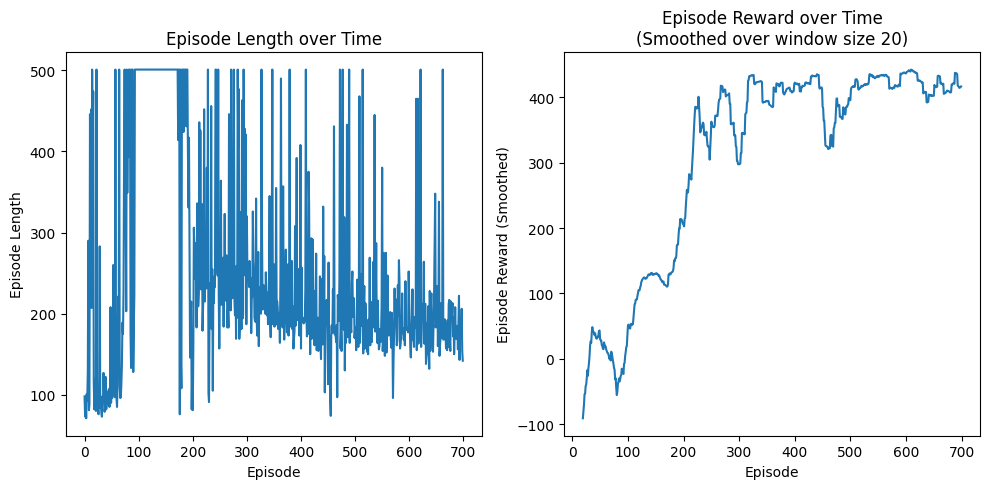

In [ ]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

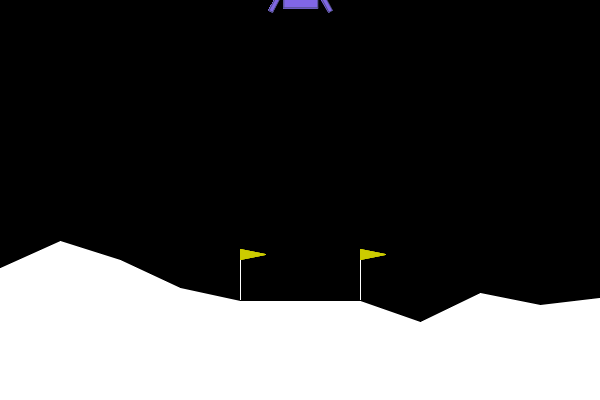

In [14]:
from IPython.display import Image as IImage


env=CustomLunarLander(continuous = True)
env_name="CustomLunarLander-v2"
env.render_mode="rgb_array"



def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32))[0].cpu().numpy()

        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

imgs = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

## 3- Obstacle class


In [ ]:

import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
from gym.utils.step_api_compatibility import step_api_compatibility

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError:
    raise DependencyNotInstalled("box2d is not installed, run `pip install gym[box2d]`")


if TYPE_CHECKING:
    import pygame


FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400





class ContactDetector(contactListener):
    def __init__(self, env):
        super().__init__()
        self.env = env


    def BeginContact(self, contact):
      bodyA, bodyB = contact.fixtureA.body, contact.fixtureB.body

      # Safely check for 'obstacle' in userData for both bodies involved in the collision
      if self.is_obstacle(bodyA) or self.is_obstacle(bodyB):
        if self.env.lander in [bodyA, bodyB]:
            self.env.obstacle_hit = True
            self.env.game_over = True  # Set game over if the lander hits an obstacle.
            # print("Game over: Lander has hit the obstacle!")
        # else:
            # print("Obstacle was hit, but not by the lander.")

      # Check if the lander itself is involved in any collision
      if self.env.lander in [bodyA, bodyB]:
          self.env.game_over = True
          # print("Game over: Lander crashed.")

      # Check for ground or obstacle contact for each leg
      for i in range(2):
        if self.env.legs[i] in [bodyA, bodyB]:
            if self.env.moon in [bodyA, bodyB]:
                self.env.legs[i].ground_contact = True
                # print(f"Leg {i + 1} made contact with the ground.")
            if self.is_obstacle(bodyA) or self.is_obstacle(bodyB):
                self.env.game_over = True  # Set game over if a leg hits an obstacle.
                # print(f"Game over: Leg {i + 1} hit an obstacle.")

    def EndContact(self, contact):
        bodyA, bodyB = contact.fixtureA.body, contact.fixtureB.body

        # Check for ground contact end for each leg
        for i in range(2):
            if self.env.legs[i] == bodyA or self.env.legs[i] == bodyB:
                if self.env.moon == bodyA or self.env.moon == bodyB:
                    self.env.legs[i]. ground_contact = False
                    # print(f"Leg {i + 1} lost contact with the ground.")

    def is_obstacle(self, body):
        """ Helper method to determine if a body is an obstacle. """
        userData = getattr(body, 'userData', {})
        return isinstance(userData, dict) and 'obstacle' in userData


class LunarLanderwithObstacle(gym.Env, EzPickle):
    """
    ### Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.

    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

    To see a heuristic landing, run:
    ```
    python gym/envs/box2d/lunar_lander.py
    ```
    <!-- To play yourself, run: -->
    <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->

    ### Action Space
    There are four discrete actions available: do nothing, fire left
    orientation engine, fire main engine, fire right orientation engine.

    ### Observation Space
    The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.

    ### Rewards
    After every step a reward is granted. The total reward of an episode is the
    sum of the rewards for all the steps within that episode.

    For each step, the reward:
    - is increased/decreased the closer/further the lander is to the landing pad.
    - is increased/decreased the slower/faster the lander is moving.
    - is decreased the more the lander is tilted (angle not horizontal).
    - is increased by 10 points for each leg that is in contact with the ground.
    - is decreased by 0.03 points each frame a side engine is firing.
    - is decreased by 0.3 points each frame the main engine is firing.

    The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

    An episode is considered a solution if it scores at least 200 points.

    ### Starting State
    The lander starts at the top center of the viewport with a random initial
    force applied to its center of mass.

    ### Episode Termination
    The episode finishes if:
    1) the lander crashes (the lander body gets in contact with the moon);
    2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
    3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
        a body which is not awake is a body which doesn't move and doesn't
        collide with any other body:
    > When Box2D determines that a body (or group of bodies) has come to rest,
    > the body enters a sleep state which has very little CPU overhead. If a
    > body is awake and collides with a sleeping body, then the sleeping body
    > wakes up. Bodies will also wake up if a joint or contact attached to
    > them is destroyed.

    ### Arguments
    To use to the _continuous_ environment, you need to specify the
    `continuous=True` argument like below:
    ```python
    import gym
    env = gym.make(
        "LunarLander-v2",
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    )
    ```
    If `continuous=True` is passed, continuous actions (corresponding to the throttle of the engines) will be used and the
    action space will be `Box(-1, +1, (2,), dtype=np.float32)`.
    The first coordinate of an action determines the throttle of the main engine, while the second
    coordinate specifies the throttle of the lateral boosters.
    Given an action `np.array([main, lateral])`, the main engine will be turned off completely if
    `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (in particular, the
    main engine doesn't work  with less than 50% power).
    Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left
    booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely
    from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

    `gravity` dictates the gravitational constant, this is bounded to be within 0 and -12.

    If `enable_wind=True` is passed, there will be wind effects applied to the lander.
    The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`.
    `k` is set to 0.01.
    `C` is sampled randomly between -9999 and 9999.

    `wind_power` dictates the maximum magnitude of linear wind applied to the craft. The recommended value for `wind_power` is between 0.0 and 20.0.
    `turbulence_power` dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for `turbulence_power` is between 0.0 and 2.0.

    ### Version History
    - v2: Count energy spent and in v0.24, added turbulance with wind power and turbulence_power parameters
    - v1: Legs contact with ground added in state vector; contact with ground
        give +10 reward points, and -10 if then lose contact; reward
        renormalized to 200; harder initial random push.
    - v0: Initial version

    <!-- ### References -->

    ### Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power


        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        ##
        self.obstacle_hit = False

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None
        self.prev_altitude = None
        self.hover_counter = 0
        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001|0x0400,  #maskBits=0x001 | 0x0080,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0200,
                    maskBits=0x001|0x0400 ,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)


        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # Create the obstacle positioned in the middle of the screen horizontally
        # and at a strategic vertical position
        middle_x = VIEWPORT_W / SCALE / 2  # Middle of the screen horizontally
        obstacle_y = VIEWPORT_H / SCALE / 2 +2# A third up the screen vertically

        self.obstacle: Box2D.b2Body = self.world.CreateStaticBody(
        position=(middle_x, obstacle_y),
        shapes=polygonShape(box=(0.75, 0.2)),  # Dimensions of the obstacle
        userData={'obstacle': True}
        )
        self.obstacle.color1 = (255, 0, 0)  # Red color for visibility
        self.obstacle.color2 = (180, 0, 0)


        obstacle_fixture = fixtureDef(
        shape=polygonShape(box=(0.75, 0.2)),
        density=0,  # Static body does not need density
        friction=0.9,
        restitution=0.0,
        categoryBits=0x0400,
        maskBits=0x0100 | 0x0200  # Should interact with lander and legs
        )
        self.obstacle.CreateFixture(obstacle_fixture)


        self.drawlist = [self.lander] + self.legs+[self.obstacle]

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0300,
                maskBits=0x0010|0x0400,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            + 10 * state[6]
            + 10 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.03

        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if not self.lander.awake:
            terminated = True
            reward = +200
            # Check for collision with the obstacle
        pos = self.lander.position
        vel = self.lander.linearVelocity


        if self.obstacle_hit:
          reward -= 100  # Apply penalty for hitting the obstacle
          self.game_over = True  # Optionally end the game
          self.obstacle_hit = False  # Reset the flag
        # if reward<-200:
        #   reward+=-100
          terminated=True
          self.game_over = True
        # print("reward=", reward)
        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[box2d]`"
            )

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((VIEWPORT_W, VIEWPORT_H))

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())



      # Draw the terrain and other elements


        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (0, 0, 0), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

                for x in [self.helipad_x1, self.helipad_x2]:
                    x = x * SCALE
                    flagy1 = self.helipad_y * SCALE
                    flagy2 = flagy1 + 50
                    pygame.draw.line(
                        self.surf,
                        color=(255, 255, 255),
                        start_pos=(x, flagy1),
                        end_pos=(x, flagy2),
                        width=1,
                    )
                    pygame.draw.polygon(
                        self.surf,
                        color=(204, 204, 0),
                        points=[
                            (x, flagy2),
                            (x, flagy2 - 10),
                            (x + 25, flagy2 - 5),
                        ],
                    )
                    gfxdraw.aapolygon(
                        self.surf,
                        [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
                        (204, 204, 0),
                    )

        self.surf = pygame.transform.flip(self.surf, False, True)

        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
            s[0] is the horizontal coordinate
            s[1] is the vertical coordinate
            s[2] is the horizontal speed
            s[3] is the vertical speed
            s[4] is the angle
            s[5] is the angular speed
            s[6] 1 if first leg has contact, else 0
            s[7] 1 if second leg has contact, else 0

    Returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):

    total_reward = 0
    steps = 0
    s, info = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, terminated, truncated, info = step_api_compatibility(env.step(a), True)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or terminated or truncated:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if terminated or truncated:
            break
    if render:
        env.close()
    return total_reward


class LunarLanderContinuous:
    def __init__(self):
        raise error.Error(
            "Error initializing LunarLanderContinuous Environment.\n"
            "Currently, we do not support initializing this mode of environment by calling the class directly.\n"
            "To use this environment, instead create it by specifying the continuous keyword in gym.make, i.e.\n"
            'gym.make("LunarLander-v2", continuous=True)'
        )




from gym.envs.registration import registry, register, make, spec

register(
    id='LunarLanderDefault-v3',
    entry_point='__main__:LunarLanderwithObstacle',
    max_episode_steps=1000,
    reward_threshold=200,
)



### Training


In [ ]:

env=LunarLanderwithObstacle(continuous = True)
env_name="CustomLunarLander-v2"
env.render_mode="rgb_array"

LR = 0.001
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
NUM_EPISODES = 800
DISCOUNT_FACTOR = 0.99
TARGET_ENTROPY = -1.0

# Train SAC
agent = SACAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
    target_entropy=TARGET_ENTROPY,
)
stats = agent.train(NUM_EPISODES)

<ipython-input-8-d69ad675e933>:50: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_val, target)


Episode 10 of 800  Time Step: 657
Episode 20 of 800  Time Step: 1763
Episode 30 of 800  Time Step: 3510
Episode 40 of 800  Time Step: 5142
Episode 50 of 800  Time Step: 6945
Episode 60 of 800  Time Step: 9794
Episode 70 of 800  Time Step: 12518
Episode 80 of 800  Time Step: 15320
Episode 90 of 800  Time Step: 18387
Episode 100 of 800  Time Step: 22165
Episode 110 of 800  Time Step: 24976
Episode 120 of 800  Time Step: 26950
Episode 130 of 800  Time Step: 29154
Episode 140 of 800  Time Step: 31636
Episode 150 of 800  Time Step: 35092
Episode 160 of 800  Time Step: 37494
Episode 170 of 800  Time Step: 39689
Episode 180 of 800  Time Step: 44242
Episode 190 of 800  Time Step: 49223
Episode 200 of 800  Time Step: 53577
Episode 210 of 800  Time Step: 58400
Episode 220 of 800  Time Step: 62880
Episode 230 of 800  Time Step: 67167
Episode 240 of 800  Time Step: 71535
Episode 250 of 800  Time Step: 76203
Episode 260 of 800  Time Step: 81190
Episode 270 of 800  Time Step: 86046
Episode 280 of 80

In [ ]:
from google.colab import files

# # # # save the trained actor
torch.save(agent.actor, "obstacle.pt")
files.download('obstacle.pt')
# loading the trained actor
loaded_actor = torch.load("obstacle.pt")
loaded_actor.eval()
print(loaded_actor)

Actor(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_std): Linear(in_features=256, out_features=2, bias=True)
)


### Results

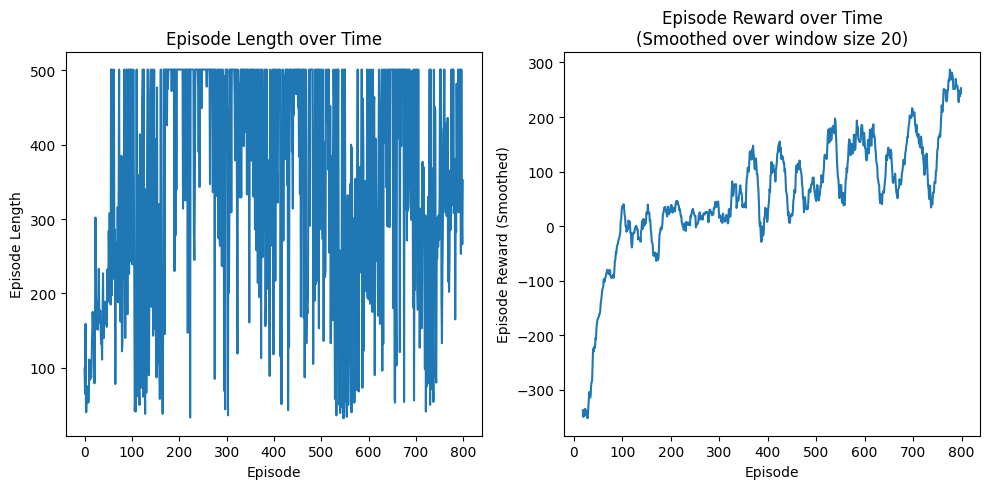

In [ ]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

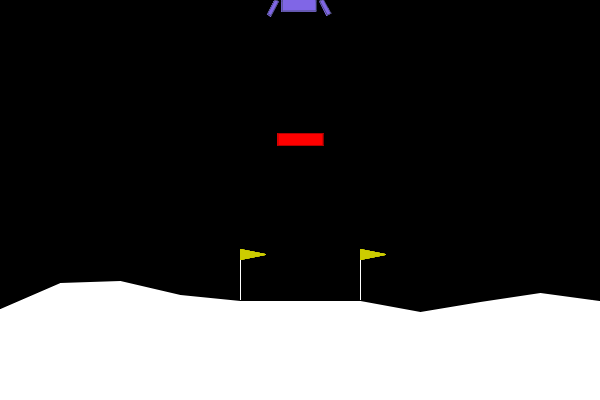

In [ ]:
from IPython.display import Image as IImage


env=LunarLanderwithObstacle(continuous = True)
env_name="CustomLunarLander-v2"
env.render_mode="rgb_array"



def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32))[0].cpu().numpy()

        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

imgs = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")